### Workbook -- FCNN

In this workbook, we will instantiate and train a Fully Connected Neural Network, and compare its predictions to our old (photoz) method.

In [23]:
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

In [24]:
# Global variables
BATCH_SZ = 256
LR = 1e-4  # learning rate
NE = 40  # number of epochs

In [25]:
# Load data
from preprocess import load

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag", zmax=2)

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51255, 7)
Label size [input_size,]:		 (51255,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


In [27]:
data[42]

array([ 0.95228636, 18.54376534, 17.71243758, 17.22634938, 16.91313614,
       16.68552963, 16.55135358])

In [28]:
features

array(['res', 'u_cmodel_mag', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'Y_cmodel_mag'], dtype=object)

Let's visualize our inputs. First, we can plot the 1D histogram for any of our input features:

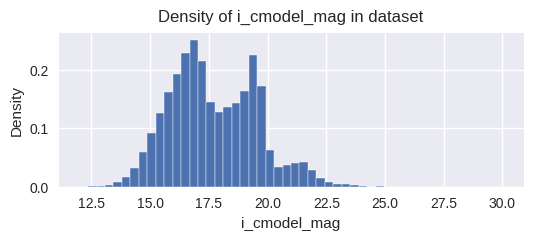

In [3]:
# Input visualization
from visualize import histogram_input

histogram_input(data, features, plot_feature="i_cmodel_mag", nbins=50, xrange=(12,30))

Next, we can also view how our labels align with any of the features in a 2D plot:

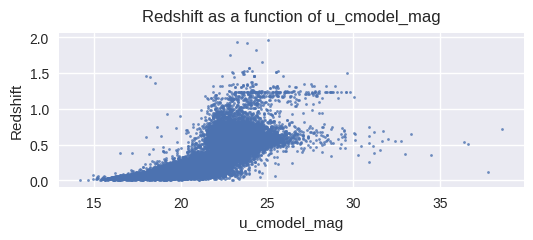

In [4]:
from visualize import plot_labels_features

plot_labels_features(data, labels, features, plot_feature="u_cmodel_mag", yrange=None)

### Model instantiation and training

In [5]:
from preprocess import preprocess_split, time_elapsed
from model import SimpleFCNN, run_model

# model initialization
simple_fcnn = SimpleFCNN(num_features=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_fcnn.parameters(), lr=LR)

# Check for CUDA, then default to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

simple_fcnn.to(device)

# Data preparation
train_set, val_set, test_set = preprocess_split(data, labels, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SZ, shuffle=True)

loss_list = []
val_loss_list = []

t0 = time.time()
for e in range(1,NE+1):

    # training
    loss = run_model(simple_fcnn, "fcnn", device, train_loader, criterion, optimizer, train=True)
    loss_list.append(loss)

    # validation
    val_loss = run_model(simple_fcnn, "fcnn", device, val_loader, criterion, train=False)
    val_loss_list.append(val_loss)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t "\
            +f"Val loss: {val_loss:.4f}\t t elapsed: {time_elapsed(t0,time.time())} mins")

Device: cuda
Epoch 05	 Train loss: 0.0096	 Val loss: 0.0127	
Epoch 10	 Train loss: 0.0085	 Val loss: 0.0078	
Epoch 15	 Train loss: 0.0080	 Val loss: 0.0078	
Epoch 20	 Train loss: 0.0076	 Val loss: 0.0069	
Epoch 25	 Train loss: 0.0074	 Val loss: 0.0072	
Epoch 30	 Train loss: 0.0070	 Val loss: 0.0071	


In [6]:
# How does the model perform on unseen data?
test_loss = run_model(simple_fcnn, "fcnn", device, test_loader, criterion, train=False)

print(f"Final test loss: {test_loss:.4f}")

Final test loss: 0.0074


Next, we would like to visualize how our training went!

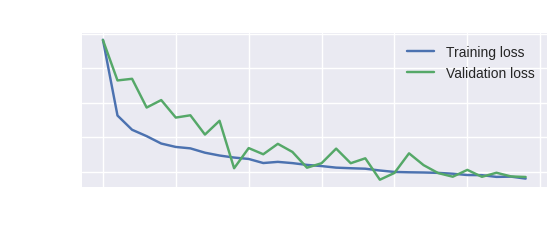

In [7]:
from visualize import plot_loss

plot_loss(loss_list, val_loss_list,
#           transparent=True,
#           savepath="./fcnn_loss_curve.png",
          )

Next, we would like to visualize the results of the model. In other words, given our set of test inputs, what kinds of outputs does our model predict?

----------------- Linear Regression Parameters -----------------
Slope:					 0.7732946017963901
Intercept:				 0.04884892836779908
Coefficient of determination (R2):	 0.8831687385255428
p-value for null hypothesis:		 0.0
Standard error on the slope:		 0.0032079251539626845


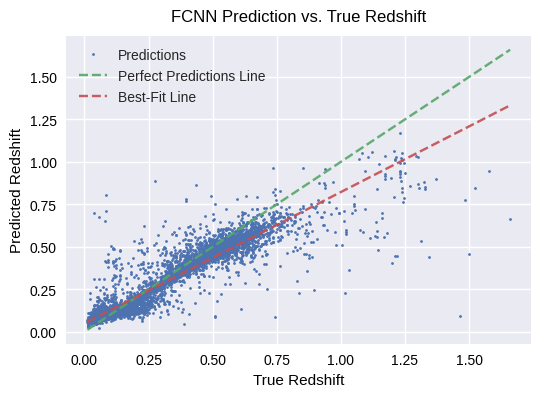

In [8]:
from model import get_predictions
from visualize import visualize_predictions

test_labels, test_preds = get_predictions(test_set, simple_fcnn, device=device, model_type='fcnn')

visualize_predictions(test_labels, test_preds, "FCNN", 
                      #savepath="./fcnn_preds.png", 
                      #transparent=True,
                      )

Now, let's compare this to the Old Method vs. True Redshift plot

----------------- Linear Regression Parameters -----------------
Slope:					 0.7749786599967133
Intercept:				 0.09488197736421511
Coefficient of determination (R2):	 0.594149957427952
p-value for null hypothesis:		 0.0
Standard error on the slope:		 0.002767528232247858


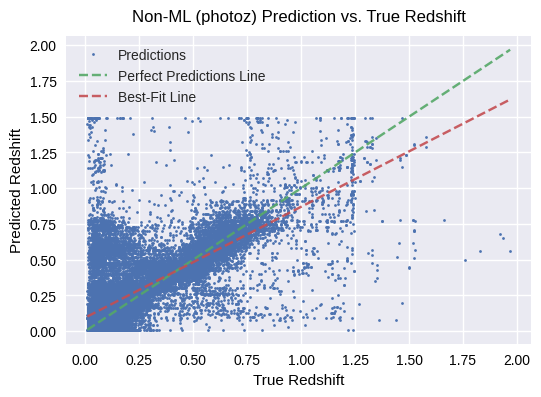

In [9]:
old_z, true_z, features = load("./data/specz_photoz.csv", mode="all", zmax=2)

visualize_predictions(true_z.flatten(), old_z.flatten(), "Non-ML (photoz)", 
                      #savepath="./photoz_preds.png",
                      #transparent=True,
                      )

Finally, beyond the visualizations, we would like a quantitative assessment of the FCNN's performance vs. the Non-ML (photoz) method. Let's compare their MSEs.

In [10]:
print(f"FCNN's Mean-Squared Error on the test set: {test_loss:.4f}")

old_method_mse = mean_squared_error(true_z.flatten(), old_z.flatten())

print(f"Non-ML (photoz) Mean-Squared Error:", round(old_method_mse,4))

percent_diff = np.abs(test_loss-old_method_mse)/(0.5*(test_loss+old_method_mse))*100

print(f"Percent difference: {round(percent_diff,2)}%")

FCNN's Mean-Squared Error on the test set: 0.0074
Non-ML (photoz) Mean-Squared Error: 0.0259
Percent difference: 111.17%
